# Рекомендация тарифов

***Цель проекта*** - построить модель, которая будет рекомендовать тот или иной тариф с учетом данных о поведении клиентов телеком компании.

***Задачи проекта:***

1. Изучить предоставленные данные;
2. Провести исследовательский анализ данных;
3. Построить несколько рекомендательных моделей и выбрать оптимальный вариант;
4. Проверить выбранную модель на адекватность.
    

## Откройте и изучите файл

Для проведения исследования необходимо открыть и изучить файл, что и сделаем.

In [1]:
#подключаем все необходимые пакеты

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

In [2]:
#откроем файл

df = pd.read_csv('/datasets/users_behavior.csv')

#выведем первые 10 строк на экран

df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
#изучим информацию о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод

Файл открыт, изучен, данные готовы для разделения на три выборки.

## Анализ влияния факторов, включаемых в модель

### Исследование зависимости включенных в тарифы услуг

Для того, чтобы понять, нужно ли включать в модель те или иные данные, изучим зависят ли количественные данные друг от друга. 
Для начала изучим влияет ли количество звонков на общую длительность. Предположим, что чем больше звонков, тем дольше общая продолжительность разговоров, но это не точно, поэтому построим график рассеивания.

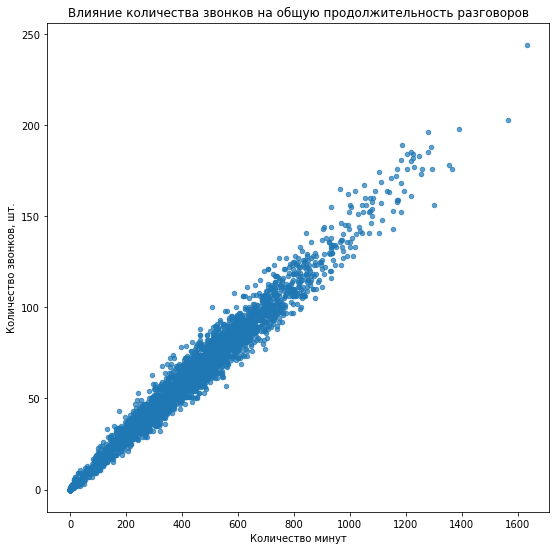

In [4]:
#построим график рассеивания, показывающий зависимость общей продолжительности разговоров от 
#количества звонков

#зададим все необходимые параметры

df.plot(kind='scatter', x = 'minutes', y = 'calls', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества звонков на общую продолжительность разговоров')

#зададим подписи осей

plt.xlabel('Количество минут')
plt.ylabel('Количество звонков, шт.')

#выведем график на экран

plt.show()

Исходя из графика видно, что количество звонко в вмесяц и общая продолжительность разговоров зависит линейно. Для того, чтобы оценить корреляцию численно, рассчитаем коэффициент корреляции.

In [5]:
#посчитаем коэффициент корреляции между количеством звонков и общей продолжительностью разговоров

print('Коэффициент корреляции между количеством звонков и общей продолжительностью разговоров:', df['minutes'].corr(df['calls']).round(2))

Коэффициент корреляции между количеством звонков и общей продолжительностью разговоров: 0.98


Как мы видим, общая продолжительность звонков действительно увеличивается с количеством звонков, поэтому этот фактор точно нужно учитывать при построении модели.

Аналогично изучим влияние количества звонков на количество отправленных сообщений, количества звонков на объем использованного интернет-трафика, зависимость между количеством минут и отправленными сообщениями и т.д. со всеми количественными данными.

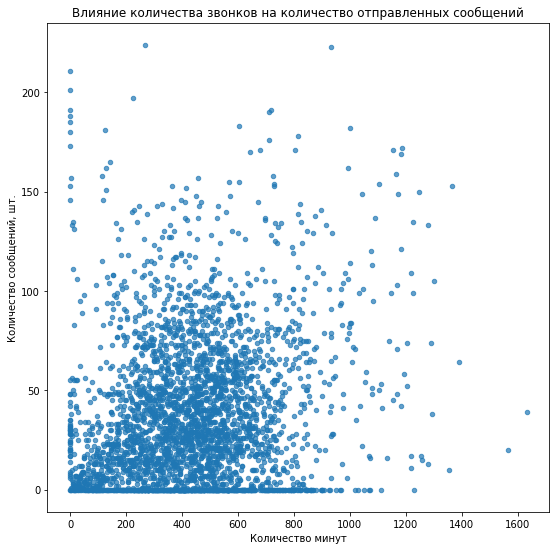

In [6]:
#построим график рассеивания, показывающий зависимость количества отправленных сообщений от 
#количества звонков

#зададим все необходимые параметры

df.plot(kind='scatter', x = 'minutes', y = 'messages', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества звонков на количество отправленных сообщений')

#зададим подписи осей

plt.xlabel('Количество минут')
plt.ylabel('Количество сообщений, шт.')

#выведем график на экран

plt.show()

Как мы видим, есть часть абонентов, которые не отправляют сообщений и не звонят, поэтому для корректного расчета коэффициента корреляции, исключим их из анализа.

In [7]:
#сделаем срез абонентов, которые отправляют сообщения и совершают звонки, и 
#сохраним данные в новом датасете df_messages_calls

df_messages_calls = df.query('messages != 0 and minutes !=0')

#выведем первые 10 строк датасета на экран

df_messages_calls.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Теперь еще раз построим график зависимости количества отправленных сообщений от количества минут с учетом новых данных.

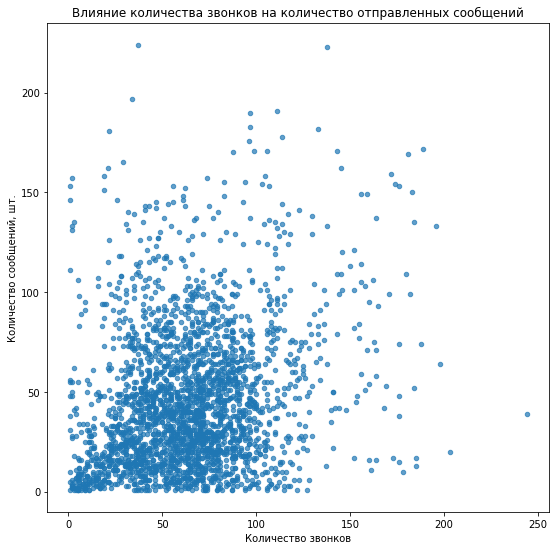

In [8]:
#построим график рассеивания, показывающий зависимость количества отправленных сообщений от 
#количества звонков

#зададим все необходимые параметры

df_messages_calls.plot(kind='scatter', x = 'calls', y = 'messages', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества звонков на количество отправленных сообщений')

#зададим подписи осей

plt.xlabel('Количество звонков')
plt.ylabel('Количество сообщений, шт.')

#выведем график на экран

plt.show()

In [9]:
#посчитаем коэффициент корреляции между количеством звонков и количеством отправленных сообщений

print('Коэффициент корреляции между количеством звонков и количеством отправленных сообщений:', df['calls'].corr(df['messages']).round(2))

Коэффициент корреляции между количеством звонков и количеством отправленных сообщений: 0.18


Как мы видим, корреляция между количеством минут разговора и количеством отправленных сообщений слабая. Предположим, что есть абоненты, которые не пользуются интернетом, исключим их из анализа.

In [10]:
#сделаем срез абонентов, которые пользуются всеми телекомунникационными услугами и сохраним 
#результат в датасете df_total

df_total = df_messages_calls.query('mb_used !=0')

#выведем первые 10 строк датасета на экран

df_total .head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


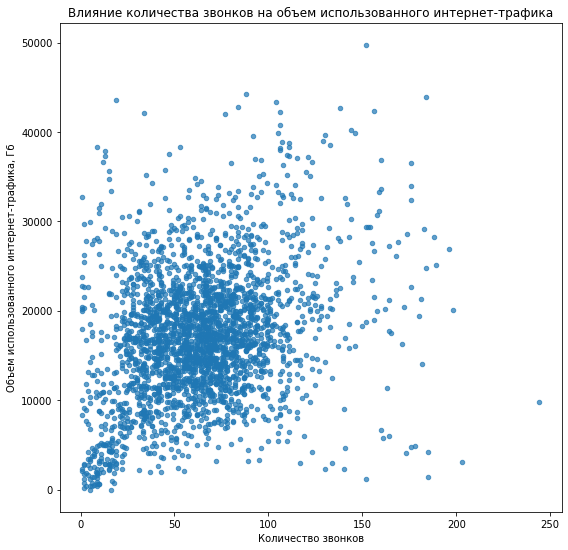

In [11]:
#построим график рассеивания, показывающий зависимость объема использованного интернет-трафика от 
#количества звонков

#зададим все необходимые параметры

df_total.plot(kind='scatter', x = 'calls', y = 'mb_used', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества звонков на объем использованного интернет-трафика')

#зададим подписи осей

plt.xlabel('Количество звонков')
plt.ylabel('Объем использованного интернет-трафика, Гб')

#выведем график на экран

plt.show()

In [12]:
#посчитаем коэффициент корреляции между количеством звонков и объемом использованного интернет-трафика

print('Коэффициент корреляции между количеством звонков и объемом использованного интернет-трафика:', df['calls'].corr(df['mb_used']).round(2))

Коэффициент корреляции между количеством звонков и объемом использованного интернет-трафика: 0.29


Как мы видим, корреляция между количеством минут разговора и объемом использованного инетнет-трафика также слабая.

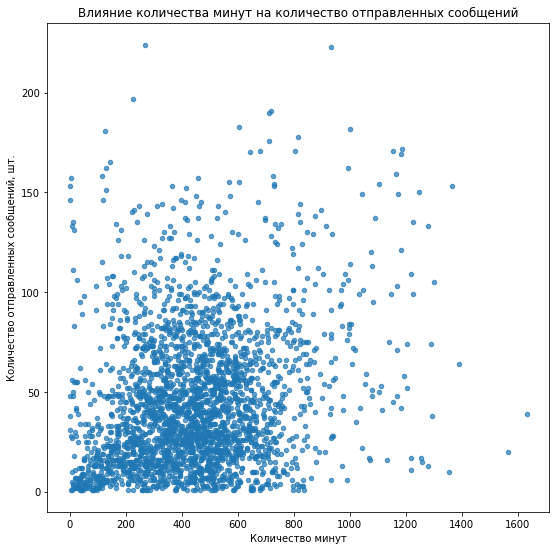

In [13]:
#построим график рассеивания, показывающий зависимость количества минут от количества 
#отправленных сообщений

#зададим все необходимые параметры

df_total.plot(kind='scatter', x = 'minutes', y = 'messages', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества минут на количество отправленных сообщений')
 
#зададим подписи осей

plt.xlabel('Количество минут')
plt.ylabel('Количество отправленных сообщений, шт.')

#выведем график на экран

plt.show()

In [14]:
#посчитаем коэффициент корреляции между количеством минут и количеством отправленных сообщений

print('Коэффициент корреляции между количеством минут и количеством отправленных сообщений:', df['minutes'].corr(df['messages']).round(2))

Коэффициент корреляции между количеством минут и количеством отправленных сообщений: 0.17


Как видно исходя из графика и значения коэффициента корреляции, зависимость между количеством минут и количеством отправленных сообщений слабая.

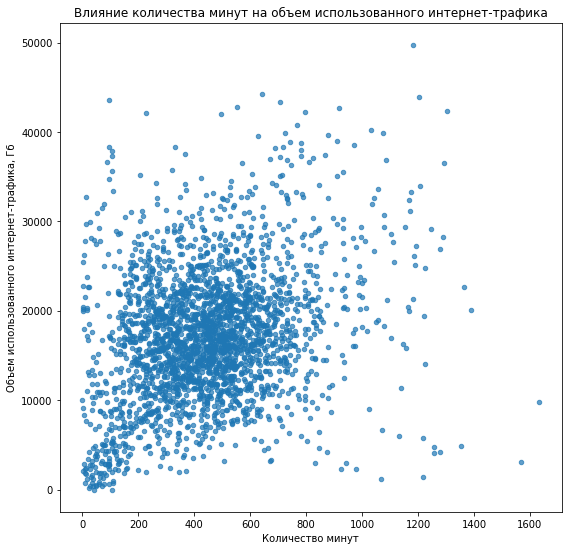

In [15]:
#построим график рассеивания, показывающий зависимость количества минут от объема использованного 
#интернет-трафика

#зададим все необходимые параметры

df_total.plot(kind='scatter', x = 'minutes', y = 'mb_used', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества минут на объем использованного интернет-трафика')

#зададим подписи осей

plt.xlabel('Количество минут')
plt.ylabel('Объем использованного интернет-трафика, Гб')

#выведем график на экран

plt.show()

In [16]:
#посчитаем коэффициент корреляции между количеством минут и объемом использованного интернет-трафика

print('Коэффициент корреляции между количеством минут и объемом использованного интернет-трафика:', df['minutes'].corr(df['mb_used']).round(2))

Коэффициент корреляции между количеством минут и объемом использованного интернет-трафика: 0.28


Как видно исходя из графика и значения коэффициента корреляции, зависимостьмежду количеством минут и объемом использованного интернет-трафика слабая.

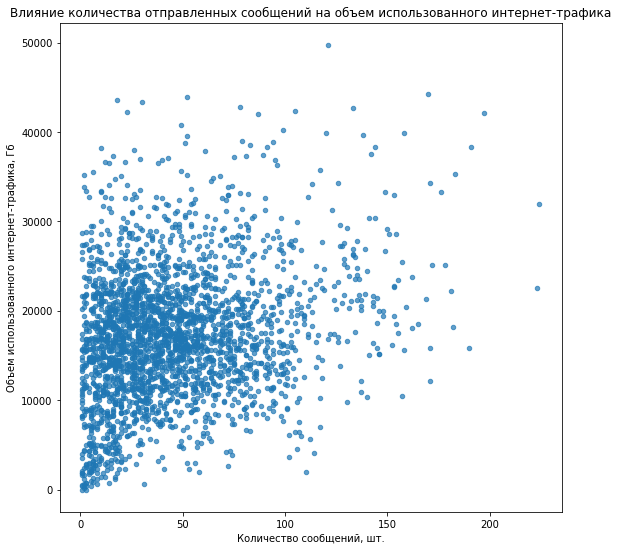

In [17]:
#построим график рассеивания, показывающий зависимость объема использованного интернет-трафика
# от количества отправленных сообщений

#зададим все необходимые параметры

df_total.plot(kind='scatter', x = 'messages', y = 'mb_used', figsize = (9,9), alpha = 0.7, 
       title = 'Влияние количества отправленных сообщений на объем использованного интернет-трафика')

#зададим подписи осей

plt.xlabel('Количество сообщений, шт.')
plt.ylabel('Объем использованного интернет-трафика, Гб')

#выведем график на экран

plt.show()

In [18]:
#посчитаем коэффициент корреляции между количеством минут и объемом использованного интернет-трафика

print('Коэффициент корреляции между количеством минут и объемом использованного интернет-трафика:', df['messages'].corr(df['mb_used']).round(2))

Коэффициент корреляции между количеством минут и объемом использованного интернет-трафика: 0.2


График и коэффициент корреляции гооврит нам о том, что зависимость между количеством минут и объемом использованного интернет-трафика слабая.

### Вывод

Исходя из проведенного анализа зависимости количественных показателей друг от друга, выяснилось, что только количество звонков оказывает существенное влияние на общую продолжительность потраченных минут, что логично. Остальные факторы не оказывают существенного влияния, поэтому можно исключить их из данных, необходимых для построения модели.

## Разбейте данные на выборки

Разобьём данные на три выборки: тренировочную, валидационную и тестовую в соотношении 3:1:1. В качестве признаков выберем все столбцы, кроме того, который содержит информацию о тарифе. В качестве целевого признака - наоборот, возьмем столбец с булевыми значениями 'is_ultra'.

In [19]:
#выделим признаки для построения модели

features = df.drop(['is_ultra','messages','mb_used'],axis=1)

#выделим целевой признак

target = df['is_ultra']

In [20]:
#разделим данные на три выборки

df_train, df_valid, df_test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

In [21]:
#проверим корректно ли разделились данные 

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1928 non-null   float64
 1   minutes   1928 non-null   float64
 2   messages  1928 non-null   float64
 3   mb_used   1928 non-null   float64
 4   is_ultra  1928 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 75.4 KB


In [22]:
#проверим корректно ли разделились данные 

df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 1928 to 2570
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   minutes   643 non-null    float64
 2   messages  643 non-null    float64
 3   mb_used   643 non-null    float64
 4   is_ultra  643 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 25.2 KB


In [23]:
#проверим корректно ли разделились данные 

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 2571 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     643 non-null    float64
 1   minutes   643 non-null    float64
 2   messages  643 non-null    float64
 3   mb_used   643 non-null    float64
 4   is_ultra  643 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 25.2 KB


### Вывод

Данные разделены на выборки и готовы к построению моделей машинного обучения.

## Исследуйте модели

Для исследования выберем две модели: случайный лес и логистическую регрессию.

### Исследование модели "случайный лес"

In [24]:
#выделем признаки и целевой признак в разрезе выборок

features_train = df_train.drop(['is_ultra','messages','mb_used'],axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra','messages','mb_used'],axis=1) 
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra','messages','mb_used'],axis=1) 
target_test = df_test['is_ultra']

Для того, чтобы понять, какая модель "случайного леса" оптимальна, будем задавать различные гиперпараметры: число деревьев и глубину. 


In [25]:
#найдем лучшие параметры для модели "случайный лес"

best_model = None
best_result = 0
for est in range(1,6): #зададим число деревьев от 1 до 5
    model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=4) #инициируем вызов модели "случайный лес"  с глубиной 5
    model_random_forest.fit(features_train,target_train) #обучим модель на тренировочных данных
    predictions_random_forest = model_random_forest.predict(features_valid) #предскажем результат на валидационныъ данных
    result = accuracy_score(target_valid,predictions_random_forest) #рассчитаем метрику accuracy на валидационных данных и предсказаниях
    if result > best_result:
        best_est = est
        best_model = model_random_forest 
        best_result = result

print("Accuracy наилучшей модели на валидационной выборке:", best_result, 'Наилучшее количество деревьев:', best_est)

Accuracy наилучшей модели на валидационной выборке: 0.7620528771384136 Наилучшее количество деревьев: 4


In [26]:
#найдем лучшие параметры для модели "случайный лес"

best_model_1 = None
best_result_1 = 0
for est in range(1,51): #зададим количество деревьев от 1 до 50
    model_random_forest_1 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=5) 
    model_random_forest_1.fit(features_train,target_train)
    predictions_random_forest_1 = model_random_forest_1.predict(features_valid)
    result_1 = accuracy_score(target_valid,predictions_random_forest_1) 
    if result_1 > best_result_1:
        best_est_1 = est
        best_model_1 = model_random_forest_1
        best_result_1 = result_1

print("Accuracy наилучшей модели на валидационной выборке:", best_result_1, 'Наилучшее количество деревьев:', best_est_1)

Accuracy наилучшей модели на валидационной выборке: 0.7636080870917574 Наилучшее количество деревьев: 7


In [27]:
#найдем лучшие параметры для модели "случайный лес"

best_model_2 = None
best_result_2 = 0
for est in range(1,201): #зададим количество деревьев от 1 до 200
    model_random_forest_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=3) #зададим глубину равную 4 
    model_random_forest_2.fit(features_train,target_train)
    predictions_random_forest_2 = model_random_forest_2.predict(features_valid)
    result_2 = accuracy_score(target_valid,predictions_random_forest_2) 
    if result_2 > best_result_2:
        best_est_2 = est
        best_model_2 = model_random_forest_2
        best_result_2 = result_2

print("Accuracy наилучшей модели на валидационной выборке:", best_result_2, 'Наилучшее количество деревьев:', best_est_2)

Accuracy наилучшей модели на валидационной выборке: 0.7527216174183515 Наилучшее количество деревьев: 1


### Исследование модели логистической регрессии

Для сравнения эффективностии модели "случайного леса", изучим модель логистической регрессии.

In [28]:
#инициируем вызов модели логистической регрессии

model = LogisticRegression(random_state=12345)

#обучим модель

model.fit(features_train,target_train)

#рассчитаем метрики на валидационных данных

result = model.score(features_valid,target_valid) 

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7387247278382582


### Вывод

Исходя из изучения модели "случайного леса" видно, что при подборе гипермпараметров (число деревьев от 1 до 200 и глубина от 4 до 5) наилучший результат метрики accuracy на валидационной выборке достигается при двух вариантах: количестве деревьев 4 и глуби не 4, и количестве деревьев 7 и глубине 5. Далее проверим, как работает эта модель при двух вариантах заданных гиперпараметров на тестовой выборке. Модель логистической регрессии на валидационной выборке показывает результат accuracy ниже.

## Проверьте модель на тестовой выборке

Для того, чтобы понять, какая модель подходит для исследования лучше, проверим работу моделей на тестовых данных.

### Проверка модели "случайный лес" 

Модель "случайный лес" проверим при двух вариантах гипермпараметров: глубине деревьев 4 и 7 и глубине 4 и 5.

In [31]:
#задаем наилучшие параметры модели, полученные на валидационной выборке

model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=4, max_depth=4) 

#обучим модель

model_random_forest.fit(features_train,target_train)

#предскажем результат на тестовой выборке

predictions_random_forest = model_random_forest.predict(features_test)

#рассчитаем метрику accuracy на тестовых данных

result = accuracy_score(target_test,predictions_random_forest) 


print("Accuracy наилучшей модели на тестовой выборке:", result)

Accuracy наилучшей модели на тестовой выборке: 0.744945567651633


In [32]:
#задаем наилучшие параметры модели, полученные на валидационной выборке

model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=7, max_depth=5) 

#обучим модель

model_random_forest.fit(features_train,target_train)

#предскажем результат на тестовой выборке

predictions_random_forest = model_random_forest.predict(features_test)

#рассчитаем метрику accuracy на тестовых данных

result = accuracy_score(target_test,predictions_random_forest) 


print("Accuracy наилучшей модели на тестовой выборке:", result)

Accuracy наилучшей модели на тестовой выборке: 0.7387247278382582


### Проверка модели логистической регрессии 

In [30]:
#инициируем вызов модели логистической регрессии

model = LogisticRegression(random_state=12345)

#обучаем модель

model.fit(features_train,target_train)

#вычисляем метрику accuracy на тестовых данных

result = model.score(features_test,target_test) 

print("Accuracy модели логистической регрессии на тестовой выборке:", result)

Accuracy модели логистической регрессии на тестовой выборке: 0.7309486780715396


### Вывод

Исходя из проверки моделей "случайный лес" и модели логистической регрессии видно, что оптимальный результат показывает модель "случайный лес" при количестве деревьев 4 и глубине 4, как на валидационной, так и на тестовой выборках (0,76 и 0,75 (если округлять)) показатель accurancy соответственно). Что касается модели логистической регрессии, то accurancy тут несколько ниже как на валидационной, так и на тестовой выборках (0,74 и 0,73 соответственно), что может гооврить о недообучении модели.

## Проверка модели на адекватность

Тут я честно пыталась разобраться с Dummy Classifier, но не получилось. В целом, не уверена, что поняла задачу, поставленную в проекте правильно, т.к. для меня эта тема оказалась очень сложной для понимания(

Для проверки адекватности модели применим 2 способа: посчитаем вероятность угадывания модели по сравнению с количеством по выборке и сравним нашу модель с моделью Dummy Classifier.

In [42]:
#рассчитаем долю адекватности константной величины

relevance = df['is_ultra'].value_counts() / df.shape[0]

#выведем значение на экран

relevance

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Из результата расчета видно, что наша модель предсказывает результат с accurancy выше, чем константа (0,75 и 0,69 соответственно), что говорит об целесообразности использования модели.

In [43]:
#рассчитаем accurancy Dummy модели

strategies = ['most_frequent'] #зададим стратегию предсказания

dummy_results = [] #сохраним результат в пустой список
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42) #иницируем вызов модели Dummy

    dc.fit(features_train, target_train) #обучим модель
    result = dc.score(features_test, target_test) #рассчитаем accuracy 
    dummy_results.append({strategy: result}) #добавим результат 

pd.DataFrame(dummy_results) #выведем результат на экран

,most_frequent
0,0.695179


Исходя из результата сравнения модели "случайный лес" с моделью Dummy, мы видим, что ее использование оправдано, поскольку показатель accurancy несколько выше (0,75 против 0,70).